<span>
<b>Author:</b> <a href="http://pages.di.unipi.it/ruggieri/">Salvatore Ruggieri</a><br/>
<b>Python version:</b>  3.x<br/>
</span>
required modules: <b>pyroaring, pyfim</b>

<code>
> pip install pyroaring
> conda install -c conda-forge pyfim
> pip install lightgbm
</code>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import dd
import pandas as pd
import numpy as np
import seaborn as sns

# Part I

In [2]:
# Sample data: credit.csv, adult.csv or any other dataset with discrete columns only.
df = pd.read_csv("data/credit.csv", sep=',', na_values='?')
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,lt_0,le_17d6,critical_or_other_existing_credit,radio_or_tv,le_38848d8,no_known_savings,ge_7,gt_2d8,male_single,none,...,real_estate,gt_52d6,none,own,from_1d6_le_2d2,skilled,le_1d2,yes,yes,good
1,from_0_lt_200,gt_31d2,existing_paid,radio_or_tv,from_38848d8_le_7519d6,lt_100,from_1_lt_4,from_1d6_le_2d2,female_div_or_dep_or_mar,none,...,real_estate,le_30d2,none,own,le_1d6,skilled,le_1d2,none,yes,bad
2,no_checking,le_17d6,critical_or_other_existing_credit,education,le_38848d8,lt_100,from_4_lt_7,from_1d6_le_2d2,male_single,none,...,real_estate,from_41d4_le_52d6,none,own,le_1d6,unskilled_resident,gt_1d2,none,yes,good
3,lt_0,gt_31d2,existing_paid,furniture_or_equipment,from_7519d6_le_11154d4,lt_100,from_4_lt_7,from_1d6_le_2d2,male_single,guarantor,...,life_insurance,from_41d4_le_52d6,none,for_free,le_1d6,skilled,gt_1d2,none,yes,good
4,lt_0,from_17d6_le_31d2,delayed_previously,new_car,from_38848d8_le_7519d6,lt_100,from_1_lt_4,gt_2d8,male_single,none,...,no_known_property,gt_52d6,none,for_free,from_1d6_le_2d2,skilled,gt_1d2,none,yes,bad


In [3]:
# DD(filename or dataframe, unprotected item, negative decision)
disc = dd.DD(df, 'foreign_worker=no', 'class=bad')
# disc = dd.DD(df, 'age=from_41d4_le_52d6', 'class=bad')
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("RD = {:f}".format(ctg.rd()))    

-----
Context = ALL
Size = 1000  Perc = 100.00%
                  |class=bad|class=good|    
foreign_worker=yes|      296|       667| 963
foreign_worker=no |        4|        33|  37
                  |      300|       700|1000
RD = 0.199265


In [4]:
# filtering condition: return None to filter out, or measure value
# contingency table ctg such that ctg.n() >= minSupp 
'''
     contingency table for independence
     =========== dec.deny === dec.grant === 
     protected     a            b     n1()
     unprotected   c            d     n2()
     ===========   m1() ===   m2()  == n()
'''
def check_rd(ctg):
    # at least 20 protected with dec.deny and p2() != 0
    if ctg.a < 20 or ctg.c==0:
        return None
    return ctg.rd()

def check_rr(ctg):
    # at least 20 protected with dec.deny and p2() != 0
    if ctg.a < 20 or ctg.c==0:
        return None
    return ctg.rr()

In [5]:
# Extract contingency tables: 
# minSupp = min support of context (negative = absolute, positive = percentage)
# topk = top k contingency tables
ctgs_rd = disc.extract(testCond=check_rd, minSupp=-20, topk=1000)

In [6]:
# print top 2 
for v, ctg in ctgs_rd[:3]:
    disc.print(ctg)
    print("RD = {:f}".format(v))

-----
Context = purpose=new_car AND checking_status=lt_0 AND own_telephone=none AND installment_commitment=gt_2d8
Size = 35  Perc = 3.50%
                  |class=bad|class=good|  
foreign_worker=yes|       26|         5|31
foreign_worker=no |        1|         3| 4
                  |       27|         8|35
RD = 0.588710
-----
Context = purpose=new_car AND checking_status=lt_0 AND own_telephone=none AND installment_commitment=gt_2d8 AND credit_amount=le_38848d8
Size = 31  Perc = 3.10%
                  |class=bad|class=good|  
foreign_worker=yes|       22|         5|27
foreign_worker=no |        1|         3| 4
                  |       23|         8|31
RD = 0.564815
-----
Context = purpose=new_car AND checking_status=lt_0 AND own_telephone=none AND credit_amount=le_38848d8
Size = 45  Perc = 4.50%
                  |class=bad|class=good|  
foreign_worker=yes|       25|        12|37
foreign_worker=no |        1|         7| 8
                  |       26|        19|45
RD = 0.550676


In [7]:
# contingency tables wrt RR
ctgs_rr = disc.extract(testCond=check_rr, minSupp=-20, topk=1000)
for v, ctg in ctgs_rr[:3]:
    disc.print(ctg)
    print("RR = {:f}".format(v))

-----
Context = purpose=new_car AND own_telephone=none AND credit_amount=le_38848d8
Size = 123  Perc = 12.30%
                  |class=bad|class=good|   
foreign_worker=yes|       49|        54|103
foreign_worker=no |        1|        19| 20
                  |       50|        73|123
RR = 9.514563
-----
Context = purpose=new_car AND own_telephone=none
Size = 147  Perc = 14.70%
                  |class=bad|class=good|   
foreign_worker=yes|       59|        68|127
foreign_worker=no |        1|        19| 20
                  |       60|        87|147
RR = 9.291339
-----
Context = own_telephone=none AND other_payment_plans=none
Size = 490  Perc = 49.00%
                  |class=bad|class=good|   
foreign_worker=yes|      139|       323|462
foreign_worker=no |        1|        27| 28
                  |      140|       350|490
RR = 8.424242


In [8]:
# contingency tables in ctgs_rd
ct_rd_set = set(ctg[1] for ctg in ctgs_rd)
# contingency tables in ctgs_rd
ct_rr_set = set(ctg[1] for ctg in ctgs_rr)
# contingency tables in both
shared = ct_rd_set & ct_rr_set
len(shared) 

652

Text(0, 0.5, 'p2')

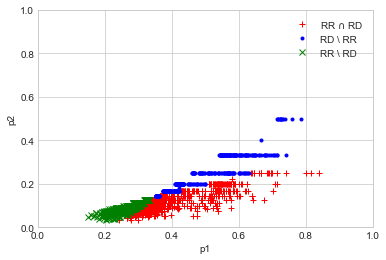

In [9]:
# plot p1() vs p2()
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([ctg.p1() for ctg in shared], [ctg.p2() for ctg in shared], '+', color='red', label=r'RR $\cap$ RD')
only_rd = ct_rd_set - shared
plt.plot([ctg.p1() for ctg in only_rd], [ctg.p2() for ctg in only_rd], '.', color='blue', label=r'RD \ RR')
only_rr = ct_rr_set - shared
plt.plot([ctg.p1() for ctg in only_rr], [ctg.p2() for ctg in only_rr], 'x', color='green', label=r'RR \ RD')
plt.legend()
plt.xlabel('p1')
plt.ylabel('p2')

# Part II

In [10]:
# Adult dataset
adult = pd.read_csv("data/adult_discrete.csv", sep=',', na_values='?')
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,(33.5-41.5],State-gov,(-inf-106068.5],Bachelors,(10.5-13.5],Never-married,Adm-clerical,Not-in-family,White,Male,(57-3368],(-inf-77.5],(39.5-40.5],United-States,-50K
1,(41.5-50.5],Self-emp-not-inc,(-inf-106068.5],Bachelors,(10.5-13.5],Married-civ-spouse,Exec-managerial,Husband,White,Male,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K
2,(33.5-41.5],Private,(196318-260259.5],HS-grad,(8.5-9.5],Divorced,Handlers-cleaners,Not-in-family,White,Male,(-inf-57],(-inf-77.5],(39.5-40.5],United-States,-50K
3,(50.5-inf),Private,(196318-260259.5],11th,(-inf-8.5],Married-civ-spouse,Handlers-cleaners,Husband,NonWhite,Male,(-inf-57],(-inf-77.5],(39.5-40.5],United-States,-50K
4,(25.5-33.5],Private,(260259.5-inf),Bachelors,(10.5-13.5],Married-civ-spouse,Prof-specialty,Wife,NonWhite,Female,(-inf-57],(-inf-77.5],(39.5-40.5],Cuba,-50K


In [11]:
# Encode categorical values
df, encoders = dd.encode(adult)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,2.0,6.0,0.0,9.0,1.0,4.0,0.0,1.0,1.0,1.0,3.0,0.0,2.0,38.0,1.0
1,3.0,5.0,0.0,9.0,1.0,2.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,38.0,1.0
2,2.0,3.0,3.0,11.0,3.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,2.0,38.0,1.0
3,4.0,3.0,3.0,1.0,0.0,2.0,5.0,0.0,0.0,1.0,0.0,0.0,2.0,38.0,1.0
4,1.0,3.0,4.0,9.0,1.0,2.0,9.0,5.0,0.0,0.0,0.0,0.0,2.0,4.0,1.0


In [12]:
# df has categorical features only
df.dtypes

age               category
workclass         category
fnlwgt            category
education         category
education-num     category
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain      category
capital-loss      category
hours-per-week    category
native-country    category
class             category
dtype: object

In [13]:
# split train test
from sklearn.model_selection import train_test_split

X = df[df.columns.drop('class')]
y = df['class']
X_train, X_test, y_train, y_test, adult_train, adult_test = train_test_split(X, y, adult.copy(), test_size=0.33, random_state=42)

In [14]:
# training model and make predictions 
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
# add predicted class in the adult_test (decoding back)
adult_test['predicted'] = encoders['class'].inverse_transform(clf.predict(X_test).astype(int))
adult_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,predicted
7762,(-inf-25.5],Private,(260259.5-inf),HS-grad,(8.5-9.5],Never-married,Other-service,Not-in-family,White,Male,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K,-50K
23881,(-inf-25.5],Private,(157936.5-196318],12th,(-inf-8.5],Never-married,Sales,Own-child,White,Female,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K,-50K
30507,(-inf-25.5],Local-gov,(260259.5-inf),HS-grad,(8.5-9.5],Never-married,Handlers-cleaners,Other-relative,NonWhite,Male,(-inf-57],(-inf-77.5],(39.5-40.5],United-States,-50K,-50K
28911,(-inf-25.5],Private,(196318-260259.5],Some-college,(9.5-10.5],Never-married,Sales,Own-child,White,Female,(-inf-57],(-inf-77.5],(-inf-35.5],United-States,-50K,-50K
19484,(41.5-50.5],Private,(196318-260259.5],HS-grad,(8.5-9.5],Never-married,Machine-op-inspct,Unmarried,NonWhite,Male,(-inf-57],(-inf-77.5],(50.5-inf),Puerto-Rico,-50K,-50K


In [15]:
# discrimination in test set
disc = dd.DD(adult_test, 'sex=Male', 'class=-50K', 'predicted=-50K', na_values={'nan'}) 
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("TPR Male = {:f}".format(ctg.tpru()))
    print("TPR Female = {:f}".format(ctg.tprp()))
    print("tpr_diff = {:f}".format(ctg.tpr_diff()))

-----
Context = ALL
Size = 16118  Perc = 100.00%
sex=Female                                         sex=Male
          |predicted=-50K|predicted=+50K|                    |predicted=-50K|predicted=+50K|     
class=-50K|          4652|            91| 4743     class=-50K|          6785|           676| 7461
class=+50K|           262|           338|  600     class=+50K|          1226|          2088| 3314
          |          4914|           429| 5343               |          8011|          2764|10775
TPR Male = 0.846960
TPR Female = 0.946683
tpr_diff = -0.099723


In [16]:
# Extract contingency tables: 
ctgs_tpr = disc.extract(testCond=lambda ctg: (None if ctg.Pu() < 20 or ctg.Pp() < 20 else ctg.tpr_diff()), minSupp=-100, topk=1000)

In [17]:
for v, ctg in ctgs_tpr[:3]:
    disc.print(ctg)
    print("TPR Male = {:f}".format(ctg.tpru()))
    print("TPR Female = {:f}".format(ctg.tprp()))
    print("tpr_diff = {:f}".format(v))

-----
Context = occupation=Exec-managerial AND hours-per-week=(40.5-50.5] AND fnlwgt=(157936.5-196318] AND native-country=United-States
Size = 123  Perc = 0.76%
sex=Female                                       sex=Male
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|            10|             0| 10     class=-50K|            16|            10| 26
class=+50K|            10|             7| 17     class=+50K|             4|            66| 70
          |            20|             7| 27               |            20|            76| 96
TPR Male = 0.800000
TPR Female = 0.500000
tpr_diff = 0.300000
-----
Context = occupation=Exec-managerial AND hours-per-week=(40.5-50.5] AND fnlwgt=(157936.5-196318] AND capital-loss=(-inf-77.5]
Size = 118  Perc = 0.73%
sex=Female                                       sex=Male
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|            10|        

In [18]:
# Fairlearn algorithms and utils (https://github.com/fairlearn/fairlearn)
# or try your preferred fair ML tool
from fairlearn.postprocessing import ThresholdOptimizer
# fairness by post-processing
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_positive_rate_parity", prefit=True, predict_method='predict')
X_train = X_train.fillna(0) # fairlearn does not manage missing values
X_test = X_test.fillna(0) # fairlearn does not manage missing values
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['sex'])
# fair-corrected predictions 
adult_test['predicted'] = encoders['class'].inverse_transform(
                            postprocess_est.predict(X_test, sensitive_features=X_test['sex']).astype(int))

In [19]:
# discrimination in test set
disc = dd.DD(adult_test, 'sex=Male', 'class=-50K', 'predicted=-50K', na_values={'nan'}) 
for ctg in disc.ctg_global():
    disc.print(ctg)
    print("TPR Male = {:f}".format(ctg.tpru()))
    print("TPR Female = {:f}".format(ctg.tprp()))
    print("tpr_diff = {:f}".format(ctg.tpr_diff()))

-----
Context = ALL
Size = 16118  Perc = 100.00%
sex=Female                                         sex=Male
          |predicted=-50K|predicted=+50K|                    |predicted=-50K|predicted=+50K|     
class=-50K|          4338|           405| 4743     class=-50K|          6718|           743| 7461
class=+50K|           231|           369|  600     class=+50K|          1213|          2101| 3314
          |          4569|           774| 5343               |          7931|          2844|10775
TPR Male = 0.847056
TPR Female = 0.949442
tpr_diff = -0.102386


In [20]:
# Extract contingency tables: 
ctgs_tpr_post = disc.extract(testCond=lambda ctg: (None if ctg.Pu() < 20 or ctg.Pp() < 20 else ctg.tpr_diff()), minSupp=-100, topk=1000)

In [21]:
for v, ctg in ctgs_tpr_post[:3]:
    disc.print(ctg)
    print("TPR Male = {:f}".format(ctg.tpru()))
    print("TPR Female = {:f}".format(ctg.tprp()))
    print("tpr_diff = {:f}".format(v))

-----
Context = occupation=Exec-managerial AND hours-per-week=(40.5-50.5] AND fnlwgt=(157936.5-196318] AND capital-loss=(-inf-77.5]
Size = 118  Perc = 0.73%
sex=Female                                       sex=Male
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|             9|             2| 11     class=-50K|            16|            11| 27
class=+50K|            11|             6| 17     class=+50K|             5|            58| 63
          |            20|             8| 28               |            21|            69| 90
TPR Male = 0.761905
TPR Female = 0.450000
tpr_diff = 0.311905
-----
Context = occupation=Exec-managerial AND hours-per-week=(40.5-50.5] AND fnlwgt=(157936.5-196318]
Size = 131  Perc = 0.81%
sex=Female                                       sex=Male
          |predicted=-50K|predicted=+50K|                  |predicted=-50K|predicted=+50K|   
class=-50K|             9|             2| 11     class=-50K|       

<AxesSubplot:ylabel='Density'>

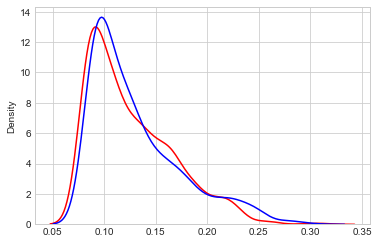

In [22]:
sns.set_style('whitegrid')
sns.kdeplot(np.array([v for v, _ in ctgs_tpr_post]), bw_adjust=1.0, color='r')
sns.kdeplot(np.array([v for v, _ in ctgs_tpr]), bw_adjust=1.0, color='b')